# 🧠 Generate simulated EEG

In this notebook we will:
- use **generators** and **iterators** to generate signals
- Apply **decorators** to wrap functions
- Practice *args, **kwargs
- Write simple **OOP** generator
- Use **asyncio** for streaming (producer/consumer)
- *(Bonus)* Load a **real EEG dataset** with MNE package

In [2]:
import time
import random
import asyncio
from functools import wraps

## 1. Decorators
We'll define a decorator that logs function calls

In [2]:
def log_calls(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Calling {func.__name__} with args={args}, kwargs={kwargs}")
        result = func(*args, **kwargs)
        return result
    return wrapper

## 2. EEG Generator (function style)
A generator that yields samples, one at a time

In [3]:
@log_calls
def eeg_generator(n_channel=4, sampling_rate=10, duration=1):
    n_samples = sampling_rate * duration
    for _ in range(n_samples):
        channel_data = [random.gauss(0, 1) for _ in range(n_channel)]
        yield channel_data
        yield '-'*35
        time.sleep(5*(1/sampling_rate))

In [4]:
for i, sample in enumerate(eeg_generator()):
    print(i, sample)

Calling eeg_generator with args=(), kwargs={}
0 [0.3288855478265939, 1.3340272096606476, 0.7472236806018029, 0.7516873308018763]
1 -----------------------------------
2 [-0.05879215362879487, -0.35856918142956945, 0.22152889924687263, -0.6512737880655417]
3 -----------------------------------
4 [0.5858717226447197, -0.9287311059304926, -0.12004954802381951, 0.6581294443751312]
5 -----------------------------------
6 [-0.10111873954652922, -0.4640743599574237, 1.0702721037678657, 0.733689359300948]
7 -----------------------------------
8 [1.4318028998591255, -1.6242790594593433, 0.8104142641945419, 0.5141702724772699]
9 -----------------------------------
10 [-0.1567147173672561, -0.8763740848642125, -1.7206302097949613, -0.17089871233546228]
11 -----------------------------------
12 [0.7508843388850531, 0.021873888233979868, -0.6835949690195858, 0.4658070944884277]
13 -----------------------------------
14 [-0.16259866532630762, 0.7935889205087115, 1.7853175640253576, 0.444097047921220

## 3. EEGStream (Generator Class)
We'll wrap the same idea inside a class that implements ```__iter__``` and ```__next__```

In [13]:
class EEGStream:
    def __init__(self, n_channel=4, sampling_rate=10, duration=1):
        self.n_channel = n_channel
        self.sampling_rate = sampling_rate
        self.duration = duration
        self._running = False

    def __iter__(self):
        self._running = True
        return self

    def __next__(self):
        if not self._running:
            raise StopIteration('The generator is stopped')
        n_samples = self.sampling_rate * self.duration
        sample = [random.gauss(0, 1) for _ in range(self.n_channel)]
        time.sleep(5*(1/self.sampling_rate))
        return sample

    def stop(self):
        self._running = False


In [14]:
stream1 = EEGStream(n_channel=4, sampling_rate=10, duration=1)

In [7]:
for i, s in zip(range(5), stream1):
    print(i, s)

0 [-0.7863851060791461, -0.6368391600845424, -0.37588067681081666, 1.4107204885218594]
1 [-0.2287200100817863, 1.0969954740331935, 1.2575665804138767, 1.7910881126501967]
2 [0.4300262442796567, 0.06822707124970134, 0.4250656622531936, 0.4696244431960428]
3 [-0.977516270779053, 1.213779215485275, 0.5747545365441928, 0.5319391088762722]
4 [0.5658530926254319, 0.6211524136299136, 0.8326279440322595, -1.3095057038705284]


In [10]:
print(next(stream1))

[-0.3117753518962274, -0.03880230232041181, 0.08430104886286165, 0.3084994716559391]


In [11]:
stream1.stop()

In [16]:
# Handle StopIteration
try:
    next(stream1)
except StopIteration as e:
    print(e)

The generator is stopped


## 4. Async Streaming (producer/consumer(s))
Here we simulate a **real-time / async** producer and consumers

In [11]:
async def eeg_producer(queues, n_channel=4, sampling_rate=10, duration=1):
    n_samples = sampling_rate * duration
    for i in range(n_samples):
        sample = [random.gauss(0, 1) for _ in range(n_channel)]
        print(f"Produced {i}: {sample}")
        for q in queues:
            await q.put((i, sample))
            await asyncio.sleep(5*(1/sampling_rate))

In [12]:
async def eeg_consumer(queue, n_samples=4, consumer_id=0):
    for _ in range(n_samples):
        i, sample = await queue.get()
        print(f"Consumer {consumer_id} consumed {i}: {sample}")
        queue.task_done()

### pub-sub Pattern

In [13]:
async def run_async_pubsub(n_channel=4, sampling_rate=10,
                           duration=1, n_consumers=2):
    n_samples = sampling_rate * duration
    queues = [asyncio.Queue() for _ in range(n_consumers)]
    producer_task = asyncio.create_task(eeg_producer(queues, n_channel,
                                                     sampling_rate, duration))
    consumers = [
        asyncio.create_task(eeg_consumer(q, n_samples=n_samples,
                                         consumer_id=i))
        for i, q in enumerate(queues)
    ]
    await asyncio.gather(*consumers)
    for q in queues:
        await q.join()
    for c in consumers:
        c.cancel()
    producer_task.cancel()

In [14]:
await run_async_pubsub(sampling_rate=4)

Produced 0: [1.3570886445272876, 0.8876025948254864, -0.2865318336351512, 0.731842853622822]
Consumer 0 consumed 0: [1.3570886445272876, 0.8876025948254864, -0.2865318336351512, 0.731842853622822]
Consumer 1 consumed 0: [1.3570886445272876, 0.8876025948254864, -0.2865318336351512, 0.731842853622822]
Produced 1: [-1.5074687065935195, 2.3162143127958474, -0.376898417215056, -0.7770444833690979]
Consumer 0 consumed 1: [-1.5074687065935195, 2.3162143127958474, -0.376898417215056, -0.7770444833690979]
Consumer 1 consumed 1: [-1.5074687065935195, 2.3162143127958474, -0.376898417215056, -0.7770444833690979]
Produced 2: [0.9514344738128407, -1.7468784065792788, 0.8827829901649111, -1.0861907268760556]
Consumer 0 consumed 2: [0.9514344738128407, -1.7468784065792788, 0.8827829901649111, -1.0861907268760556]
Consumer 1 consumed 2: [0.9514344738128407, -1.7468784065792788, 0.8827829901649111, -1.0861907268760556]
Produced 3: [1.105115341432294, -1.3502899676470932, 0.5498069105824999, -1.009829422

## 📝 Exercises
1. **Decorator extension**
    - Modify `log_calls` so it also prints *execution time* of the function
2. **Async consumer**
    - Write a new consumer that buffers samples and prints the *average of each channel* (every second)
3. **Class experiment**
    - Create a subclass of EEGStream named `NoisyEEGStream` that adds a controllable Gussian noise to the generated signal

## 🎁 Bonus: Real EEG Dataset
Physionet Motor Imagery

- Load a **public EEG dataset** to compare with our simulated signals
- We'll use **MNE** to fetch a subject's Motor Imagery data (left vs right hand)

In [17]:
!pip install -qq mne

In [30]:
import mne
import matplotlib.pyplot as plt

In [22]:
patient1 = mne.datasets.eegbci.load_data(subjects=1, runs=[6, 12])

Download complete in 09s (2.5 MB)


In [24]:
raw_data = mne.io.read_raw_edf(patient1[0], preload=True)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [27]:
raw_data

<RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [29]:
filtered_data = raw_data.copy().pick("eeg").filter(l_freq=0.5, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1057 samples (6.606 s)



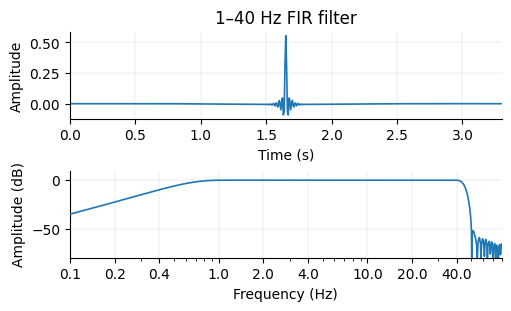

In [32]:
# Set figure size
plt.rcParams["figure.figsize"] = [5, 3]  # width, height in inches

# Filter parameters
l_freq = 1.
h_freq = 40.
sfreq = raw_data.info['sfreq']  # sampling rate

# Design FIR filter
fir_coefs = mne.filter.create_filter(
    data=None, sfreq=sfreq, l_freq=l_freq, h_freq=h_freq,
    method='fir', fir_window='hamming', verbose=False
)

# Plot time and frequency response
mne.viz.plot_filter(
    fir_coefs,
    sfreq=sfreq,
    title='1–40 Hz FIR filter',
    plot=('time', 'magnitude')  # Exclude 'delay' plot
)

plt.show()

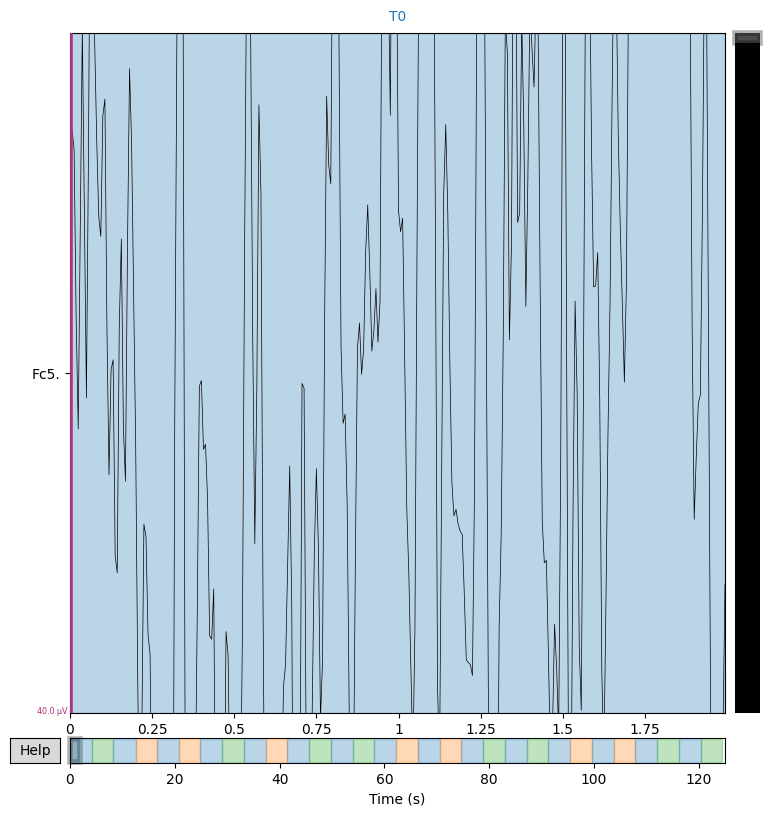

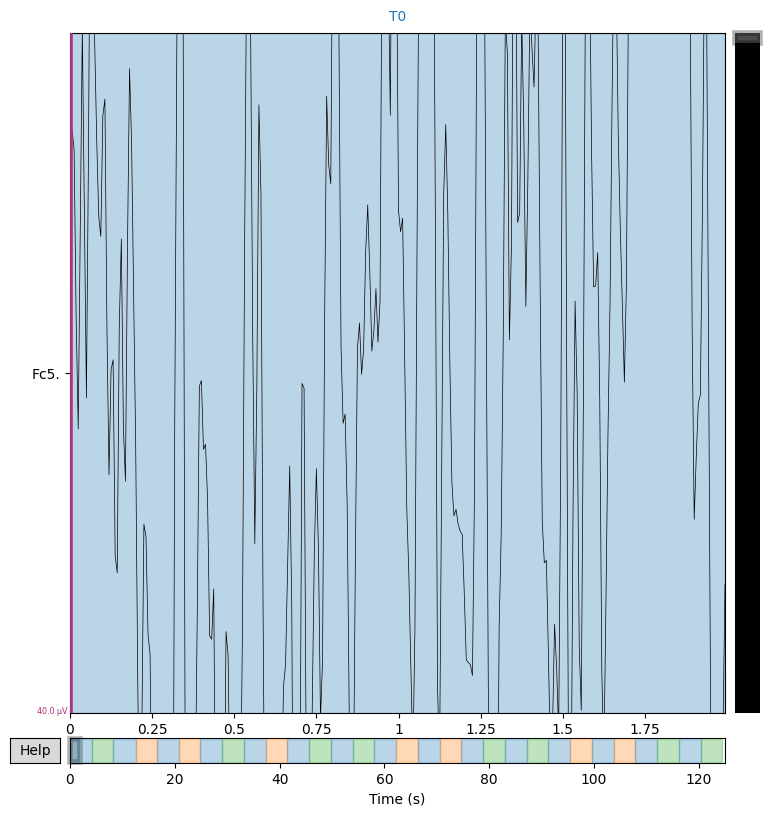

In [35]:
filtered_data.plot(duration=2, n_channels=1)